<a href="https://colab.research.google.com/github/sayakpaul/Generalized-ODIN-TF/blob/main/Evaluation_OOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
# # Retrieve the pre-trained ResNet20 model.
# # Refer to this notebook for details: https://git.io/JOJuL.
# !/home/jupyter/.local/bin/gdown --id 1-6Xp7__VMJeMBtGMByI7_GYVeIIv-1Ay 
# !/home/jupyter/.local/bin/gdown --id 1y5WfyzQ0uxvEfkjdJb4mr5nYT0ItdoIL 
# !tar xf odin_rn_model.tar.gz
# !tar xf rn_baseline_model.tar.gz

In [2]:
import sys
sys.path.append("Generalized-ODIN-TF")
from scripts import metrics

import tensorflow as tf
import tensorflow_datasets as tfds

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

tf.random.set_seed(42)
np.random.seed(42)
tfds.disable_progress_bar()

## Load the pre-trained model

In [3]:
rn_odin_model = tf.keras.models.load_model("odin_rn_model")
rn_baseline_model = tf.keras.models.load_model("rn_baseline_model")
print(f"Pre-trained models loaded.")

Pre-trained models loaded.


## Load OOD dataset -- SVHN dataset

The purpose of this work is to test a model's ability to detect out-of-distribution (OOD) samples. For that purpose, we are using the [SVHN dataset](https://http://ufldl.stanford.edu/housenumbers/) which is an OOD dataset in this case. 

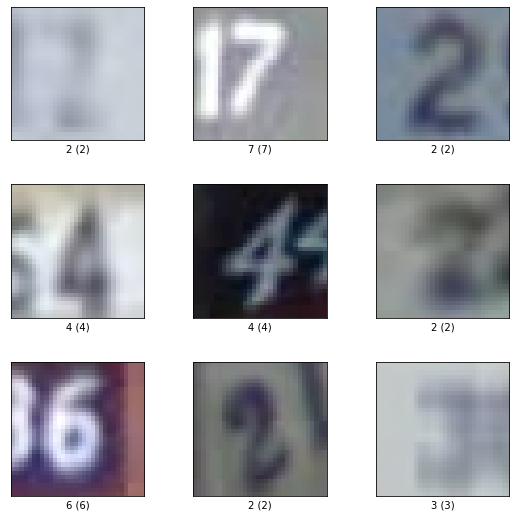

Total examples in the test set of SVHN: 26032


In [4]:
svhn_test, info = tfds.load("svhn_cropped", split="test", 
                      as_supervised=True, with_info=True)
tfds.show_examples(svhn_test, info)
print(f"Total examples in the test set of SVHN: {tf.data.experimental.cardinality(svhn_test).numpy()}")

## Prepare the data loaders

In [5]:
BATCH_SIZE = 128
AUTO = tf.data.AUTOTUNE

In [6]:
# SVHN test set
svhn_test = (svhn_test
             .map(lambda x, y: (tf.cast(x, tf.float32), y), 
                  num_parallel_calls=AUTO))

# CIFAR10 test set
(_, _), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_test = x_test.astype("float32")

In [7]:
ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
cifar10_test = ds.skip(1000).take(len(x_test) - 1000)

In [8]:
NUM_SAMPLE_MAPPING = {
    "svhn": tf.data.experimental.cardinality(svhn_test).numpy(),
    "cifar10_test": tf.data.experimental.cardinality(cifar10_test).numpy()
}
NUM_SAMPLE_MAPPING

{'svhn': 26032, 'cifar10_test': 9000}

We are skipping 1000 samples because we used them to calculate the perturbation magnitude (refer to [this notebook](https://git.io/JOTgx)). 

## Define our `scorer`

In [9]:
# Let's define our model to obtain scores.
scorer = tf.keras.Model(rn_odin_model.input, rn_odin_model.layers[-3].output)

## Perturbing utility

As per equation 9 of the paper, we will be perturbing the input images with $\epsilon$ which was calculated in [this notebook](https://git.io/JOTgx). The value we derived is **0.04**. 

In [10]:
def perturb_images(images, model, epsilon=0.04):

    test_ds_var = tf.Variable(images, trainable=True)

    with tf.GradientTape() as tape:
        # Calculate the scores.
        tape.watch(test_ds_var)
        logits = model(test_ds_var, training=False)
        loss = tf.reduce_max(logits, axis=1)
        loss = -tf.reduce_mean(loss)

    # Calculate the gradients of the scores with respect to the inputs.
    gradients = tape.gradient(loss, test_ds_var)
    gradients = tf.math.greater_equal(gradients, 0)
    gradients = tf.cast(gradients, tf.float32)
    gradients = (gradients - 0.5) * 2

    # Perturb the inputs and derive new mean score.
    # test_ds_var.assign_add(epsilon * gradients)
    static_tensor = tf.convert_to_tensor(test_ds_var)
    static_tensor = static_tensor - epsilon * gradients
    static_tensor = tf.clip_by_value(static_tensor, 0., 255.)
    
    return static_tensor

## Model evalution with AUROC & TNR@TPR95

The authors use two metrics for evaluation -- **AUROC** & **TNR@TPR95**. 

Here are the steps we will roughly be following:

1. Perturb the images using `perturb_images()`. For this, we will be using `scorer`. 
2. Pass those images to `model` to obtain predictions. From the paper - "At testing time, the class prediction can be made by either calculating $\arg \max _{i} f_{i}(\boldsymbol{x})$ or
$\arg \max _{i} h_{i}(\boldsymbol{x})$ (both will give the same predictions)."
3. Use the original labels of the dataset under evaluation and the prediction scores from (2) and calculate the metrics. 

For evaluating the baseline model, we won't be adding perturbations. 

In [11]:
# We first perturb the images from both of the datasets.

def create_pertubed_ds(ds, model, ds_name):
    num_samples = NUM_SAMPLE_MAPPING[ds_name]
    perturbed_images = np.zeros((num_samples, 32, 32, 3))
    unchanged_labels = np.zeros((num_samples, ))
    
    for i, (image, label) in enumerate(tqdm(ds)):
        image = tf.expand_dims(image, 0)
        perturbed_images[i] = perturb_images(image, model)
        unchanged_labels[i] = label
    
    perturbed_ds = tf.data.Dataset.from_tensor_slices((perturbed_images, unchanged_labels))
    return perturbed_ds

In [12]:
perturbed_svhn = create_pertubed_ds(svhn_test, scorer, "svhn")
pertubed_cifar10 = create_pertubed_ds(cifar10_test, scorer, "cifar10_test")

  0%|          | 0/26032 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

In [13]:
# We create new data loaders.
perturbed_svhn = perturbed_svhn.batch(BATCH_SIZE)
pertubed_cifar10 = pertubed_cifar10.batch(BATCH_SIZE)

In [18]:
# Calculate AUROC.
print(metrics.metric(pertubed_cifar10, perturbed_svhn, rn_odin_model, stype="generalized_odin"))

{'generalized_odin': {'TNR': 0.5418715427166565, 'AUROC': 0.9215311326230964}}


In [19]:
# Baseline AUROC (with perturbation).
cifar10_test = pertubed_cifar10.batch(BATCH_SIZE)
print(metrics.metric(pertubed_cifar10, perturbed_svhn, rn_baseline_model, stype="baseline"))

{'baseline': {'TNR': 0.4053088506453596, 'AUROC': 0.9114120185412826}}
